In [11]:
import visa
import numpy as np
import pylab as pl
import warnings
import time
from datetime import datetime
from IPython.display import display
from IPython.display import HTML, Image, Latex, Math, Markdown, SVG
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf')
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


In [12]:
# Test configuration
cycle_time = 4
sleep_time = 15 # sleep for X seconds in each cycle
repeat_counter = 1
log_data = datetime.now().strftime('%H_%M_%d_%m_%Y')

In [13]:
def oscilloscope_screenshot(repeat_counter, scope, port, interface, log_data):
    scope.encoding = 'ascii' # default 'ascii'
    scope.read_termination = None # default None
    scope.write_termination = '\r\n' # default '\r\n'
    
    vc = visa.constants # Alias for easier reading
    bufferSize = 1024

    # Serial Port Settings
    baudRate = 9600
    flowCtrl = vc.VI_ASRL_FLOW_RTS_CTS
    #flowCtrl = vc.VI_ASRL_FLOW_NONE
    #==============================================

    if interface == vc.VI_INTF_ASRL:
        lib.set_attribute(scope.session, vc.VI_ATTR_ASRL_FLOW_CNTRL, flowCtrl)
        lib.set_attribute(scope.session, vc.VI_ATTR_ASRL_BAUD, baudRate)
        port = 'RS232'
        startDelaySec = 1
    elif interface == vc.VI_INTF_USB:
        port = 'USB'
        startDelaySec = 2
    elif interface == vc.VI_INTF_GPIB:
        port = 'GPIB'
        startDelaySec = 3

    # Date information
    start_time = datetime.now()
    print('Recorded on {}'.format(start_time))

    fileSaveLocation = r'C:\Users\ahamidi\version-control\Test\ScreenShot{}_{}.png'.format(repeat_counter,log_data)
    
    #![title](fileSaveLocation)
    
    print(scope.query("*IDN?"))
    scope.write("HARDCOPY:FORMAT PNG")
    scope.write("HARDCOPY:LAYOUT PORTRait")
    scope.write("HARDCOPY:PORT " + port)
    scope.write("HARDCOPY START")

    print("Starting Transfer in: ", end = "")
    for x in range(0, startDelaySec):
        print(str.format("{0}...", startDelaySec - x), end = "")
        time.sleep(1)
    print("Now!")

    # If using RS-232 then need to disable end on termination character while reading the image data
    if lib.get_attribute(scope.session, vc.VI_ATTR_INTF_TYPE)[0] == vc.VI_INTF_ASRL:
        lib.set_attribute(scope.session, vc.VI_ATTR_ASRL_END_IN, 0)

    # Read the BMP header bytes and extract the file size
    warnings.filterwarnings("ignore", category=Warning) #The read will produce a VI_SUCCESS_MAX_CNT warning so suppress
    imgBytes = lib.read(scope.session, 14)[0]
    lengthBytes = imgBytes[2:6]
    fileSize = int.from_bytes(lengthBytes, byteorder='little', signed=False)
    bytesLeft = fileSize - 14

    # Read the rest of the image
    while bytesLeft > 0:
        imgBytes = imgBytes + lib.read(scope.session, bufferSize)[0]
        bytesLeft = bytesLeft - bufferSize

        if bytesLeft < bufferSize:
            imgBytes = imgBytes + lib.read(scope.session, bytesLeft)[0]
            bytesLeft = 0

    # Re-enable end on termination character for RS-232
    if lib.get_attribute(scope.session, vc.VI_ATTR_INTF_TYPE)[0] == vc.VI_INTF_ASRL:
        lib.set_attribute(scope.session, vc.VI_ATTR_ASRL_END_IN, 1)

    # Save the bytes to a file
    imgFile = open(fileSaveLocation, "wb")
    imgFile.write(imgBytes)
    imgFile.close()

    print("Transfer Complere!")
    print("Image saved to " + fileSaveLocation)
    img=Image(filename = fileSaveLocation, format ='jpeg', width = 400,height = 400)
    display(img)


In [14]:
def waveform_recorder(repeat_counter, scope, port, interface , log_data):
    
    scope.encoding = 'latin_1' # default 'ascii'
    scope.read_termination = '\n' # default None
    scope.write_termination = None # default '\r\n'
    
    t1 = time.perf_counter()
    r = scope.query('*opc?') # sync
    t2 = time.perf_counter()
    print('reset time: {} s'.format(t2 - t1))

#     scope.write('autoset EXECUTE') # autoset
#     t3 = time.perf_counter()
#     r = scope.query('*opc?') # sync
#     t4 = time.perf_counter()
#     print('autoset time: {} s'.format(t4 - t3))

    # io config
    scope.write('header 0')
    scope.write('data:encdg RIBINARY')
    scope.write('data:source CH2') # channel 2 :chirp signal
    scope.write('data:start 1') # first sample
    record = int(scope.query('wfmpre:nr_pt?'))
    scope.write('data:stop {}'.format(record)) # last sample
    scope.write('wfmpre:byt_nr 1') # 1 byte per sample

    # acq config
    scope.write('acquire:state 0') # (equivalent to pressing) STOP (button)
    scope.write('acquire:stopafter SEQUENCE') # single
    scope.write('acquire:state 1') # (equivalent to pressing) RUN (button)
    t5 = time.perf_counter()
    r = scope.query('*opc?') # sync
    t6 = time.perf_counter()
    print('acquire time: {} s'.format(t6 - t5))

    # data query
    t7 = time.perf_counter()
    bin_wave = scope.query_binary_values('curve?', datatype='b', container=np.array)
    t8 = time.perf_counter()
    print('transfer time: {} s'.format(t8 - t7))

    # retrieve scaling factors
    tscale = float(scope.query('wfmpre:xincr?'))
    tstart = float(scope.query('wfmpre:xzero?'))
    vscale = float(scope.query('wfmpre:ymult?')) # volts / level
    voff = float(scope.query('wfmpre:yzero?')) # reference voltage
    vpos = float(scope.query('wfmpre:yoff?')) # reference position (level)

    # error checking
    r = int(scope.query('*esr?'))
    print('event status register: 0b{:08b}'.format(r))
    r = scope.query('allev?').strip()
    print('all event messages: {}'.format(r))
    
    # create scaled vectors
    # horizontal (time)
    total_time = tscale * record
    tstop = tstart + total_time
    scaled_time = np.linspace(tstart, tstop, num=record, endpoint=False)
    # vertical (voltage)
    unscaled_wave = np.array(bin_wave, dtype='double') # data type conversion
    scaled_wave = (unscaled_wave - vpos) * vscale + voff
    waveSaveLocation = r'C:\Users\ahamidi\version-control\Test\wave_form{}_{}'.format(repeat_counter,log_data)
    np.save(waveSaveLocation,scaled_wave)
    # plotting
    #pl.step(scaled_time, scaled_wave)
    pl.plot(scaled_time, scaled_wave)
    pl.title('channel 1') # plot label
    pl.xlabel('time (seconds)') # x label
    pl.ylabel('voltage (volts)') # y label
    print("\nlook for plot window...")
    pl.show()
    pl.savefig('plot{}_{}.png'.format(repeat_counter,log_data), bbox_inches='tight')
    #print("\nend of demonstration")
#     return scaled_wave

In [15]:
rm = visa.ResourceManager()
lib = rm.visalib
vc = visa.constants
scope = rm.open_resource('GPIB0::20::INSTR')
interface = lib.get_attribute(scope.session, vc.VI_ATTR_INTF_TYPE)[0]

if ( interface != 1):
    print('Invalid port. Please ente')
else : 
    # initialize the port and scope session
    port ='GPIB'
    scope.timeout = 10000
    scope.set_visa_attribute(vc.VI_ATTR_IO_PROT,3)
    scope.write('wfmpre:nr_pt 10000')
    print(scope.interface_type)
    print("Port:  " + port)
    print("Device Query: " + scope.query('*IDN?'))
    print("Device timeout: {}".format(scope.timeout))
    print("Session ID: {} ".format(scope.session))

InterfaceType.gpib
Port:  GPIB
Device Query: TEKTRONIX,TDS 3014,0,CF:91.1CT FV:v2.21 TDS3GM:v1.00 TDS3FFT:v1.00 TDS3TRG:v1.00

Device timeout: 10000
Session ID: 136721848 


Recorded on 2018-05-01 17:23:25.058842
TEKTRONIX,TDS 3014,0,CF:91.1CT FV:v2.21 TDS3GM:v1.00 TDS3FFT:v1.00 TDS3TRG:v1.00

Starting Transfer in: 3...2...1...Now!
Transfer Complere!
Image saved to C:\Users\ahamidi\version-control\Test\ScreenShot1_17_23_01_05_2018.png


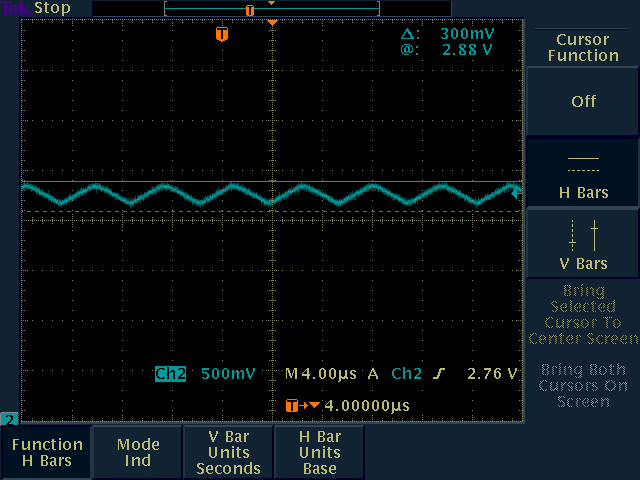

reset time: 0.004234232050976061 s
acquire time: 0.6197881484510503 s
transfer time: 0.3891964106819046 s
event status register: 0b00000000
all event messages: 0,"No events to report - queue empty"

look for plot window...


Recorded on 2018-05-01 17:23:49.365622
TEKTRONIX,TDS 3014,0,CF:91.1CT FV:v2.21 TDS3GM:v1.00 TDS3FFT:v1.00 TDS3TRG:v1.00

Starting Transfer in: 3...2...1...Now!
Transfer Complere!
Image saved to C:\Users\ahamidi\version-control\Test\ScreenShot2_17_23_01_05_2018.png


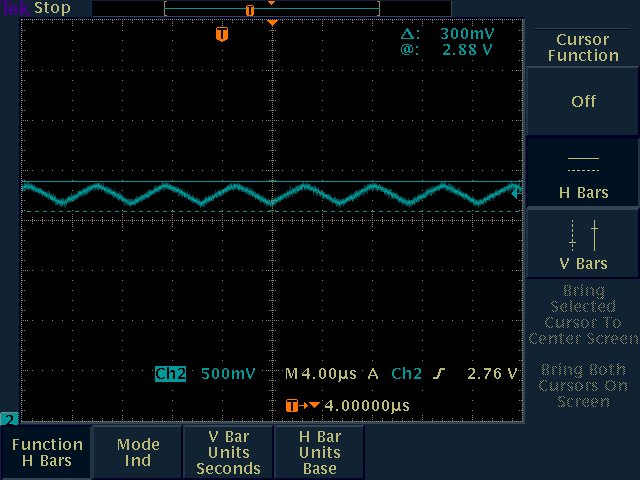

reset time: 0.003964579223804776 s
acquire time: 0.6327342148136381 s
transfer time: 0.37590184364029255 s
event status register: 0b00000000
all event messages: 0,"No events to report - queue empty"

look for plot window...


Recorded on 2018-05-01 17:24:13.650102
TEKTRONIX,TDS 3014,0,CF:91.1CT FV:v2.21 TDS3GM:v1.00 TDS3FFT:v1.00 TDS3TRG:v1.00

Starting Transfer in: 3...2...1...Now!
Transfer Complere!
Image saved to C:\Users\ahamidi\version-control\Test\ScreenShot3_17_23_01_05_2018.png


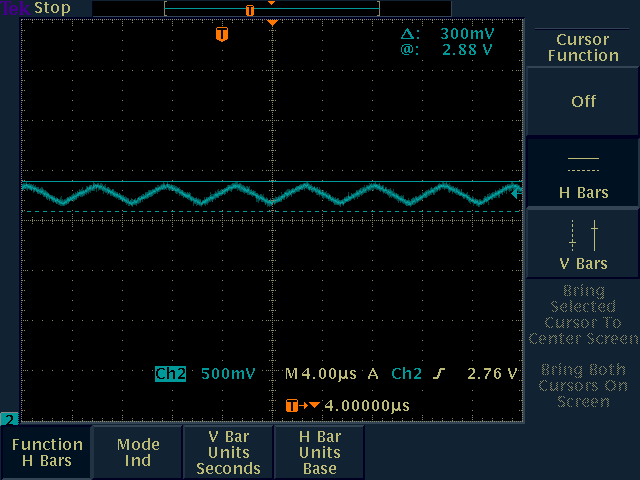

reset time: 0.003923619300735481 s
acquire time: 0.6262058857361126 s
transfer time: 0.40280705179685583 s
event status register: 0b00000000
all event messages: 0,"No events to report - queue empty"

look for plot window...


In [16]:
while(repeat_counter < cycle_time):
    oscilloscope_screenshot(repeat_counter, scope, port, interface, log_data)
    #scope.write('*cls') # clear ESR
    #scope.write('*rst') # reset
    #time.sleep(10)
    scope.write('*cls')
    waveform_recorder(repeat_counter, scope, port, interface, log_data)    
    repeat_counter += 1
    time.sleep(sleep_time)
    scope.write('*cls')

In [18]:
scope.close()
rm.close()

In [ ]:
np.load(r'C:\Users\ahamidi\version-control\Test\wave_form1.npy')